## Non-Linearity
The goal for this notebook is to re-implement the Circle model architecture but instead of exclusively using linear activation functions (that were shown to be ineffective with the circle data), non-linearity will be "wedged" between the linear layers of the existing model architecture.

In [1]:
# Let's create the new circle model with non-linear functions wedged between the existing layers
# We'll use the ubiquitous ReLU function here
import torch
from torch import nn


class CircleModel_v3(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(in_features=2, out_features=10), # Note that these are LINEAR layers (activation f'n is linear...)
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, x) -> torch.Tensor:
        return self.network(x)
    

# Instantiate a model and look at the arch
model_3 = CircleModel_v3()
model_3


CircleModel_v3(
  (network): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [2]:
# Let's redefine the functions used in the training test loop from the first notebook

### forward pass functions ###
def get_logits(X: torch.Tensor, model: torch.nn.Module, eval_mode = True) -> torch.Tensor:
    """
    Returns logits from a pass through the model as a 1d tensor.
    """
    if eval_mode:
        model.eval()
    else:
        model.train()
    
    return model(X).squeeze()

def logits_to_probs(y_logits: torch.Tensor, activation_fn) -> torch.Tensor:
    """
    Transforms logits to probabilities 
    """
    return activation_fn(y_logits)

def forward_pass(x_train: torch.Tensor, model: torch.nn.Module, eval_mode: bool, activation_fn: any) -> torch.Tensor:
    """
    Returns the probabilities after one pass through the model
    """
    return logits_to_probs(get_logits(x_train, model, eval_mode=eval_mode),
                             activation_fn)


### training metrics functions ###
def probs_to_labels(pred_probs: torch.Tensor) -> torch.Tensor:
    """
    Takes output predictions from the model in the form of probabilities and
    converts those into label values (0 or 1)
    """
    return torch.round(pred_probs)

def get_loss(y_preds: torch.Tensor, y_train: torch.Tensor, loss_fn: torch.nn) -> torch.nn:
    """
    Returns the loss between labels and predictions. Note: This function also produces side effects
    based on torch auto-grad implementation.
    """
    return loss_fn(y_preds, y_train)

def model_accuracy(model_preds: torch.Tensor, labels: torch.Tensor) -> float:
    """ Determines how well the model performs based on the number of correct
    labels it predicts.

    returns: decimal value of accuracy
    """

    # Determine the total number of predictions that the model got right.
    # Counts all indices where model preds and labels are equal
    # and returns the ratio of correct preds to total preds (aka accuracy)
    return torch.eq(model_preds, labels).sum().item()/len(model_preds)

def pass_metrics(y_preds: torch.Tensor, y_train: torch.Tensor, loss: torch.nn) -> dict:
    """
    Returns the pass metrics as a dictionary.
    """
    return {"loss": loss.item(), "accuracy": model_accuracy(y_preds, y_train)}

def display_metrics (train_metrics: dict, test_metrics: dict, epoch: int) -> None:
    """
    Prints the test and training metrics. The function only produces side effects.
    """
    print(f'Epoch: {epoch}')
    print(f'Train Loss: {train_metrics["loss"]:.2f} | Train Accuracy: {train_metrics["accuracy"]:.2f}')
    print(f'Test Loss: {test_metrics["loss"]:.2f} | Test Accuracy: {test_metrics["accuracy"]:.2f}')
    print('----------')

In [3]:
# Lets again get our training and testing data
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split

n_samples = 1000 # number of circles in our dataset

# Now to create the actual dataset. This function is pretty handy, it creates a training set for you
# (X=features, y=labels)
# It'll be interesting to see how this data is formatted
X, y = make_circles(
    n_samples, # number of vals in the dataset
    noise=0.03, # makes the circles imperfect
    random_state=42
)

# Convert from NDArray to Tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Creating the split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2, # Ratio of test data to use from full dataset; Training is the complement
    random_state=42,
)

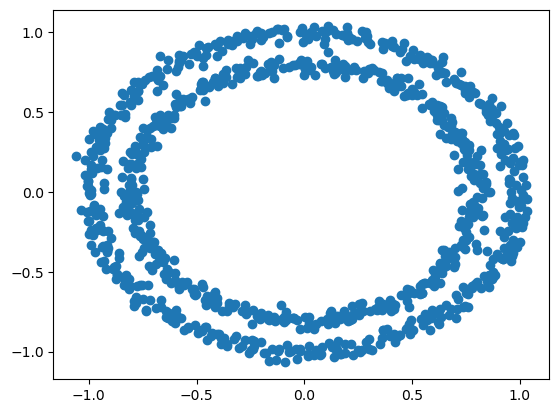

In [4]:
# Lets visualize to make sure the data looks OK
from matplotlib import pyplot as plt

plt.figure()
plt.scatter(X[:,0], X[:,1]) # Seems like we have roughly two concentric circles with different radii

In [5]:
# Now lets define the loss function/optimizer
optimizer = torch.optim.SGD(lr=0.1, params=model_3.parameters())
loss_fn = nn.BCELoss()

In [ ]:
# Define the training/testing loop
n = 1000 
for epoch in range(n):
    # Do one forward pass while also getting the training metrics.
    # Training metrics: Loss, Accuracy
    y_preds = forward_pass(X_train, model_3, False, torch.sigmoid)
    train_loss = get_loss(y_preds, y_train, loss_fn)
    train_metrics = pass_metrics(probs_to_labels(y_preds), y_train, train_loss)

    # Perform backprop steps
    # Since these operations are purely side-effects, will not define functions for them
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Now to set the model in inference mode and do a test pass
    with torch.inference_mode():
        # Do one forward pass using the test data and get test metrics
        test_preds = forward_pass(X_test, model_3, True, torch.sigmoid)
        test_loss = get_loss(test_preds, y_test, loss_fn)
        test_metrics = pass_metrics(probs_to_labels(test_preds), y_test, test_loss)
   
   # Display metrics every 10 epochs
    if epoch % 100 == 0:
        display_metrics(train_metrics, test_metrics, epoch)



Epoch: 0
Train Loss: 0.71 | Train Accuracy: 0.50
Test Loss: 0.71 | Test Accuracy: 0.50
----------
Epoch: 100
Train Loss: 0.69 | Train Accuracy: 0.50
Test Loss: 0.69 | Test Accuracy: 0.53
----------
Epoch: 200
Train Loss: 0.69 | Train Accuracy: 0.58
Test Loss: 0.69 | Test Accuracy: 0.58
----------
Epoch: 300
Train Loss: 0.69 | Train Accuracy: 0.69
Test Loss: 0.69 | Test Accuracy: 0.65
----------
Epoch: 400
Train Loss: 0.68 | Train Accuracy: 0.68
Test Loss: 0.68 | Test Accuracy: 0.65
----------
Epoch: 500
Train Loss: 0.68 | Train Accuracy: 0.72
Test Loss: 0.68 | Test Accuracy: 0.73
----------
Epoch: 600
Train Loss: 0.66 | Train Accuracy: 0.80
Test Loss: 0.67 | Test Accuracy: 0.85
----------
Epoch: 700
Train Loss: 0.64 | Train Accuracy: 0.86
Test Loss: 0.65 | Test Accuracy: 0.85
----------
Epoch: 800
Train Loss: 0.60 | Train Accuracy: 0.94
Test Loss: 0.61 | Test Accuracy: 0.90
----------
Epoch: 900
Train Loss: 0.52 | Train Accuracy: 0.98
Test Loss: 0.54 | Test Accuracy: 0.97
----------


helper_functions.py already exists, skipping download


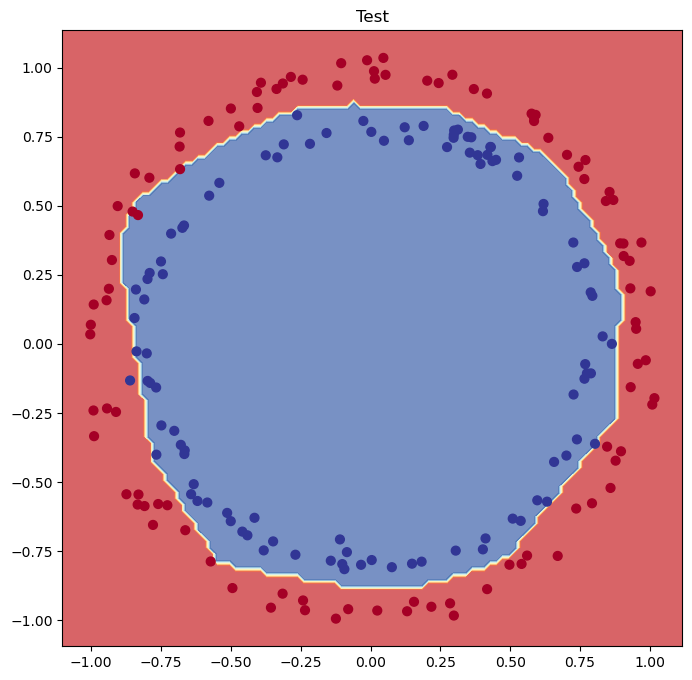

In [7]:
# Based on the telemetry above, the model is actually learning! Lets again visualize the decision boundary to see
# how it compares to before.
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

# Now can plot the decision boundary
plt.figure(figsize=(8, 8))
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity